In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc,confusion_matrix
import networkx as nx

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siddu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data = pd.read_csv("C:\\Users\\siddu\\OneDrive\\Desktop\\social_media\\conflicts_hashtag_search.csv")
print(data.head())
print(data.info())

  fromSocial                                               text  likesCount  \
0    youtube                                                NaN         NaN   
1    youtube  Russia-Ukraine Conflict: Putin Warns NATO Risk...        22.0   
2    youtube  LIVE: Russia Launches Waves of Drone Attacks o...       118.0   
3    youtube  Russian Forces Take Over Ukraine's Avdiivka | ...       166.0   
4    youtube  Russia-Ukraine War: Ukraine's Surprise Attack ...        53.0   

   commentsCount  viewsCount                  input authorMeta/name  \
0            NaN         NaN          yemencivilwar             NaN   
1            7.0      3069.0  russiaukraineconflict      CNN-News18   
2           21.0     16358.0  russiaukraineconflict       Firstpost   
3           56.0     18054.0  russiaukraineconflict       CNBC-TV18   
4            4.0      6096.0  russiaukraineconflict        DD India   

               creationDate  
0                       NaN  
1  2024-09-13T16:23:39.000Z  
2  2024-

In [4]:
data['likesCount'] = data['likesCount'].fillna(0)
data['commentsCount'] = data['commentsCount'].fillna(0)
data['viewsCount'] = data['viewsCount'].fillna(0)

In [5]:
data.drop(['authorMeta/name'], axis=1, inplace=True)

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')


In [7]:
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))


In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    tokens = word_tokenize(text.lower())
    
    # Removing stopwords and non-alphabetic characters
    tokens = [re.sub(r'\W+', '', token) for token in tokens if token.isalpha() and token not in stop_words]
    
    # Lemmatization using spaCy
    doc = nlp(" ".join(tokens))
    lemmatized = " ".join([token.lemma_ for token in doc])
    
    return lemmatized

# Apply the preprocessing function to the 'text' column
data['processed_text'] = data['text'].apply(preprocess_text)

In [9]:
analyzer = SentimentIntensityAnalyzer()

# VADER Sentiment
data['vader_sentiment'] = data['processed_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# TextBlob Sentiment
data['textblob_sentiment'] = data['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Sentiment Category
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_category'] = data['vader_sentiment'].apply(categorize_sentiment)

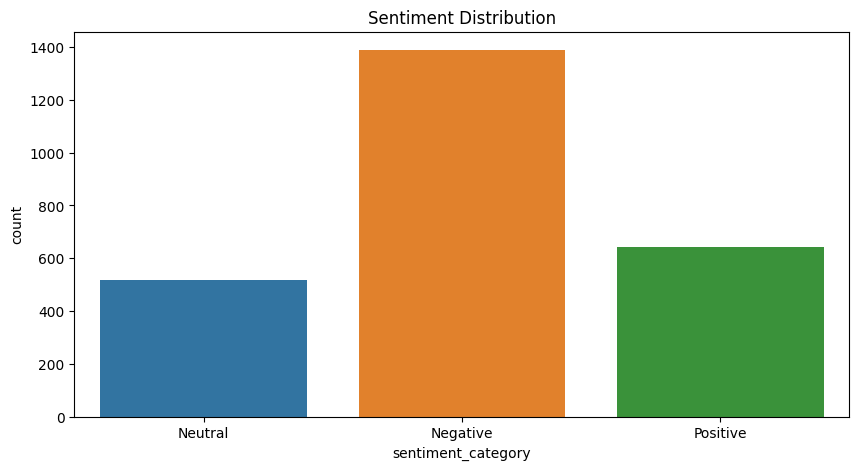

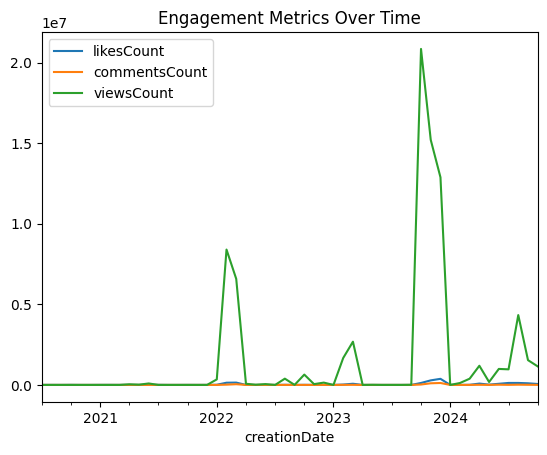

In [10]:
# Sentiment Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment_category', data=data)
plt.title("Sentiment Distribution")
plt.show()

# Engagement Metrics Over Time
data['creationDate'] = pd.to_datetime(data['creationDate'])
data.set_index('creationDate', inplace=True)
data[['likesCount', 'commentsCount', 'viewsCount']].resample('M').sum().plot()
plt.title('Engagement Metrics Over Time')
plt.show()


c:\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 120287 (\N{MATHEMATICAL SANS-SERIF BOLD CAPITAL L}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 120306 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 120303 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 120302 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 120315 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL N}) missing from current font.
  fig.canvas.print_figure(bytes_io,

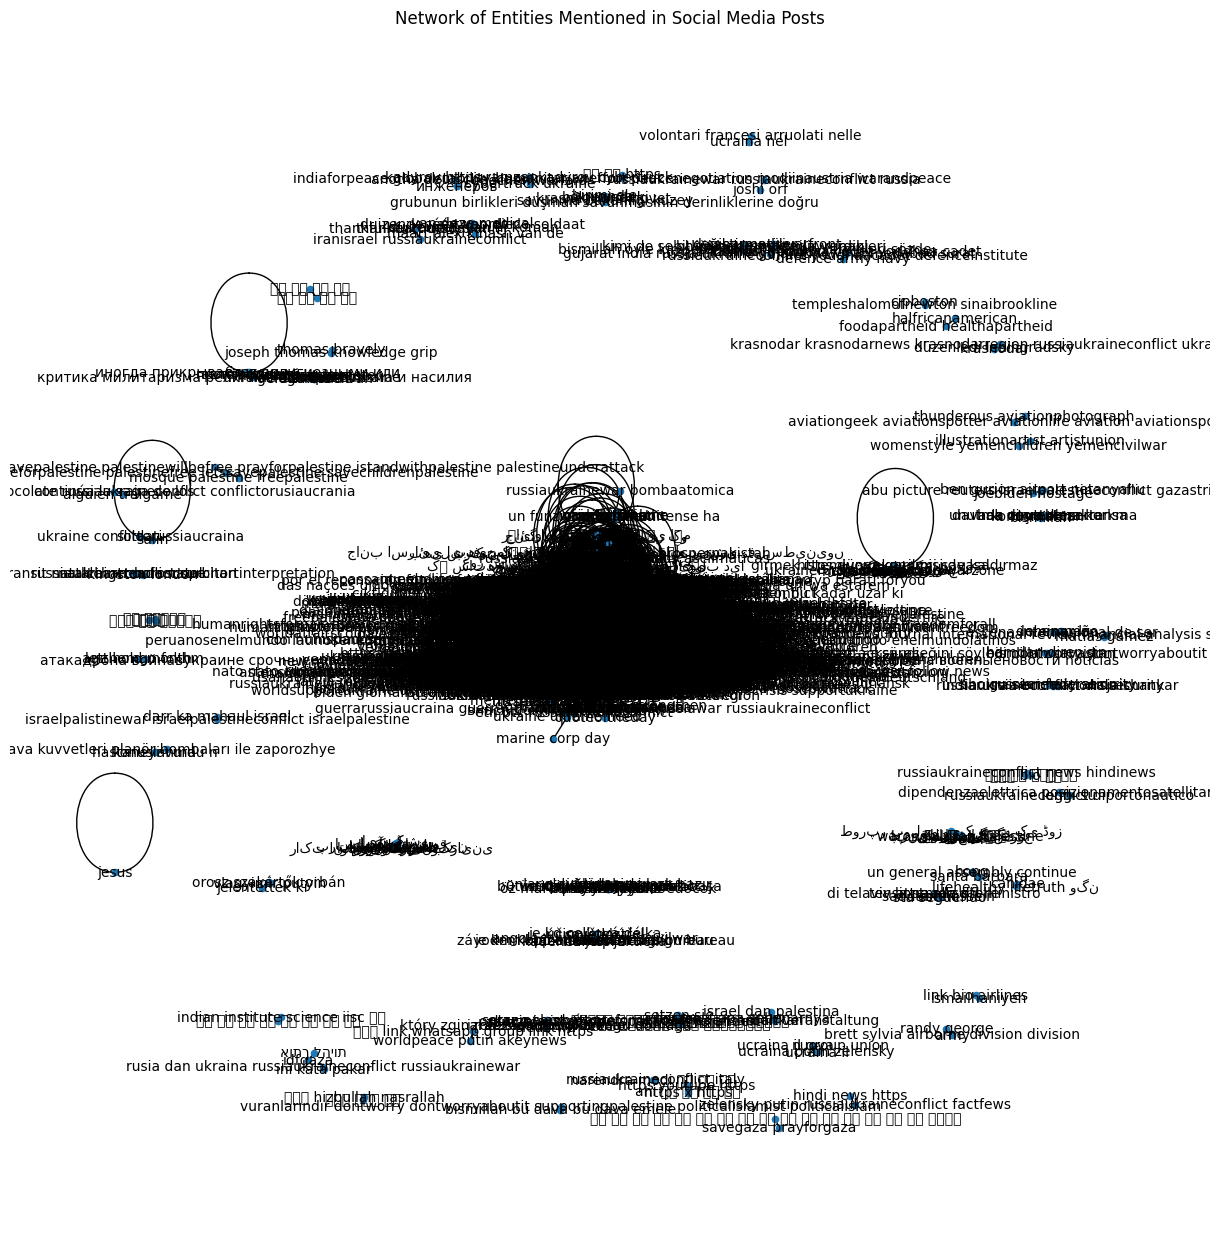

In [11]:
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

data['entities'] = data['processed_text'].apply(extract_entities)

# Building a Network Graph based on entities
G = nx.Graph()

for entities in data['entities']:
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            G.add_edge(entities[i], entities[j])

plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=20, font_size=10)
plt.title("Network of Entities Mentioned in Social Media Posts")
plt.show()


In [12]:
data['high_engagement'] = np.where(data['likesCount'] + data['commentsCount'] + data['viewsCount'] > 1000, 1, 0)

# Splitting data into training and testing sets
X = data[['vader_sentiment', 'textblob_sentiment']]
y = data['high_engagement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model Prediction
y_pred = rf_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       441
           1       0.43      0.29      0.34        69

    accuracy                           0.85       510
   macro avg       0.66      0.61      0.63       510
weighted avg       0.83      0.85      0.84       510



In [13]:
from sklearn.model_selection import GridSearchCV

# Feature Engineering: Add post length as a new feature
data['post_length'] = data['text'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)

# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
data['vader_sentiment'] = data['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
data['textblob_sentiment'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)

# Prepare target column: Engagement above a threshold
data['high_engagement'] = np.where(data['likesCount'] + data['commentsCount'] + data['viewsCount'] > 1000, 1, 0)

# Splitting data into features (X) and target (y)
X = data[['vader_sentiment', 'textblob_sentiment', 'post_length']]
y = data['high_engagement']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning: Grid Search for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_rf_model = grid_search.best_estimator_

# Model Prediction
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the best parameters found by Grid Search
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       441
           1       0.83      0.75      0.79        69

    accuracy                           0.95       510
   macro avg       0.89      0.86      0.88       510
weighted avg       0.94      0.95      0.94       510

Best Parameters from Grid Search:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


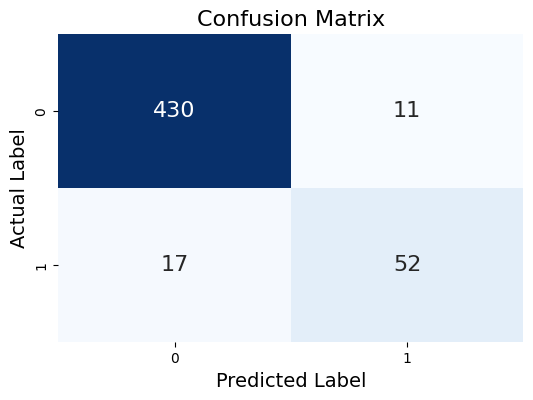

In [17]:
# Function to plot the Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
    plt.title("Confusion Matrix", fontsize=16)
    plt.ylabel('Actual Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.show()

# Plotting Confusion Matrix
plot_confusion_matrix(y_test, y_pred)


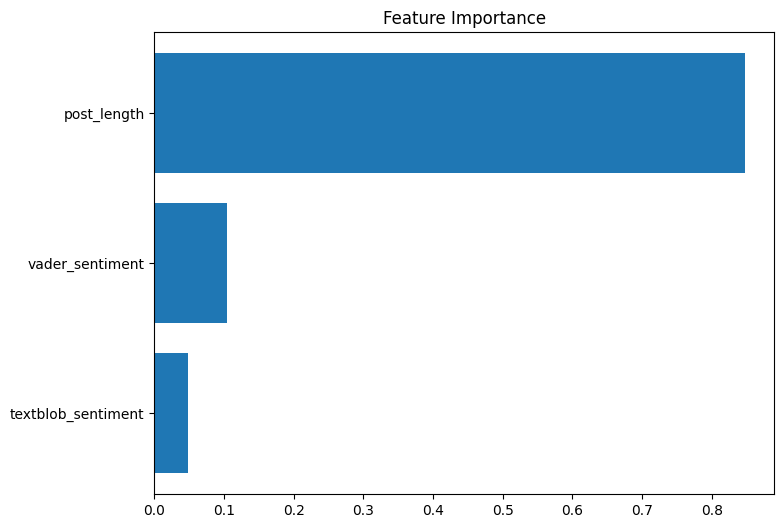

In [51]:
# Feature Importance Plot
def plot_feature_importance(model, features):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
    plt.title("Feature Importance")
    plt.show()

# Plot Feature Importance for the best Random Forest model
plot_feature_importance(best_rf_model, X.columns)

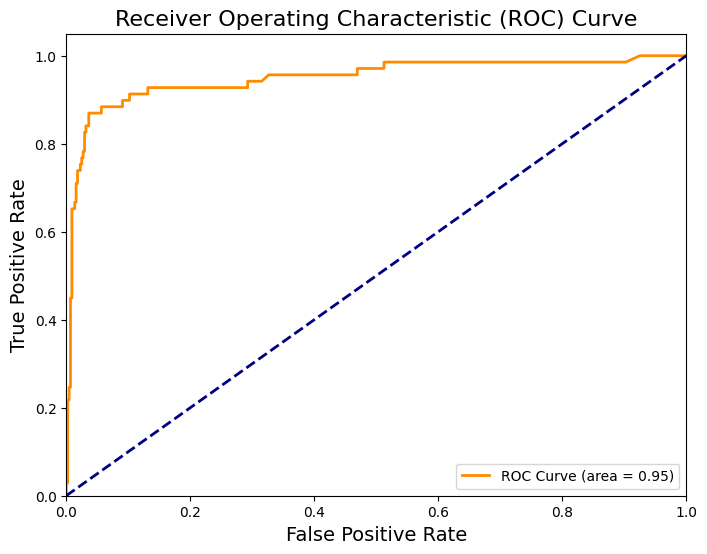

In [52]:
# ROC Curve and AUC
def plot_roc_curve(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

# Predict probability for ROC Curve
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Plot ROC Curve
plot_roc_curve(y_test, y_prob)

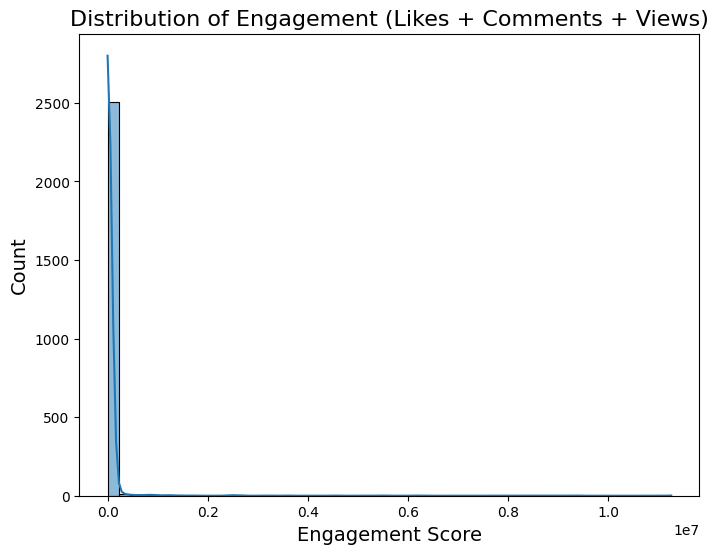

In [53]:
# Distribution of Engagement Levels (Likes + Comments + Views)
plt.figure(figsize=(8, 6))
sns.histplot(data['likesCount'] + data['commentsCount'] + data['viewsCount'], bins=50, kde=True)
plt.title("Distribution of Engagement (Likes + Comments + Views)", fontsize=16)
plt.xlabel("Engagement Score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()